In [ ]:
%pip install catboost optuna optuna-integration[catboost]

Note: you may need to restart the kernel to use updated packages.


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

In [ ]:
import os
from pathlib import Path

IN_COLAB = "COLAB_GPU" in os.environ or "google.colab" in str(get_ipython())

if not IN_COLAB:
    ROOT = Path.cwd()

    if ROOT.name == "lab02":
        LAB_ROOT = ROOT
    elif (ROOT / "lab02").exists():
        LAB_ROOT = ROOT / "lab02"
    elif ROOT.name == "notebooks":
        LAB_ROOT = ROOT.parent
    else:
        raise FileNotFoundError("Не нашёл папку lab02 от текущей директории.")

    DATA_RAW = LAB_ROOT / "data" / "raw"
    DATA_RAW.mkdir(parents=True, exist_ok=True)

    csv_path = DATA_RAW / "telco.csv"

else:
    from urllib.request import urlretrieve

    url = "https://raw.githubusercontent.com/OlegTertychnyi/ML-labs-Tert/main/lab03/data/raw/telco.csv"
    csv_path = Path("/content/telco.csv")

    if not csv_path.exists():
        urlretrieve(url, csv_path)
        print("✔ Dataset downloaded to Colab")

csv_path


PosixPath('/home/optert/ML-labs-Tert/lab03/data/raw/telco.csv')

In [69]:
df = pd.read_csv(csv_path)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [70]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["Churn"] = (df["Churn"] == "Yes").astype(int)
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [73]:
TARGET = "Churn"
ID_COLS = ["customerID"] if "customerID" in df.columns else []

X = df.drop(columns=[TARGET] + ID_COLS)
y = df[TARGET]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

num_cols, cat_cols

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

In [74]:
# Препроцессинг числовых признаков
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Препроцессинг категориальных признаков
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

# Единый трансформер для моделей
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Базовые модели для сравнения
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=42)
}


In [75]:
# Создаём пайплайны для всех моделей
pipelines = {
    model_name: Pipeline([
        ("prep", preprocessor),
        ("clf", model)
    ])
    for model_name, model in models.items()
}

# Оценка моделей
results = []

for model_name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)

    prob = pipe.predict_proba(X_test)[:, 1]
    pred = pipe.predict(X_test)

    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred),
        "ROC-AUC": roc_auc_score(y_test, prob)
    })

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.805536,0.657233,0.558824,0.604046,0.841874
1,SVM (RBF),0.791341,0.641844,0.483957,0.551829,0.790491
2,KNN (k=7),0.764372,0.554404,0.572193,0.563158,0.804810
3,Random Forest,0.776437,0.600683,0.470588,0.527736,0.819121


In [77]:
# CatBoost: берём данные без OneHot, подаём категории напрямую

cat_features_idx = [X.columns.get_loc(c) for c in cat_cols]

cb_model = CatBoostClassifier(
    iterations=500,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False,
    cat_features=cat_features_idx
)

cb_model.fit(X_train, y_train)

y_pred = cb_model.predict(X_test)
y_proba = cb_model.predict_proba(X_test)[:, 1]

results.append({
    "Model": "CatBoost",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
})

pd.DataFrame(results)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.805536,0.657233,0.558824,0.604046,0.841874
1,SVM (RBF),0.791341,0.641844,0.483957,0.551829,0.790491
2,KNN (k=7),0.764372,0.554404,0.572193,0.563158,0.804810
3,Random Forest,0.776437,0.600683,0.470588,0.527736,0.819121
4,CatBoost,0.805536,0.676056,0.513369,0.583587,0.844270


In [78]:
def build_logreg(C, penalty, l1_ratio=None):
    # Правильный подбор solver под тип регуляризации
    if penalty == "l1":
        solver = "liblinear"
        params = {"penalty": "l1", "C": C}
    elif penalty == "l2":
        solver = "lbfgs"
        params = {"penalty": "l2", "C": C}
    else:  # elasticnet
        solver = "saga"
        params = {"penalty": "elasticnet", "C": C, "l1_ratio": l1_ratio}

    model = LogisticRegression(
        solver=solver,
        max_iter=5000,
        random_state=42,
        **params
    )

    return Pipeline([
        ("prep", preprocessor),
        ("clf", model)
    ])


def objective(trial: optuna.Trial) -> float:
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)

    l1_ratio = None
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    pipe = build_logreg(C=C, penalty=penalty, l1_ratio=l1_ratio)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipe, X_train, y_train, cv=cv,
                            scoring="roc_auc", n_jobs=-1)

    return score.mean()


study_lr = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study_lr.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best AUC:", study_lr.best_value)
print("Best Params:", study_lr.best_params)


[I 2025-11-21 14:26:53,189] A new study created in memory with name: no-name-13547912-ae20-4d86-89af-1b432b48a319


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-21 14:26:59,848] Trial 0 finished with value: 0.8461231646197689 and parameters: {'penalty': 'l2', 'C': 0.9846738873614566}. Best is trial 0 with value: 0.8461231646197689.
[I 2025-11-21 14:27:03,789] Trial 1 finished with value: 0.846254108902029 and parameters: {'penalty': 'l1', 'C': 21.42302175774105}. Best is trial 1 with value: 0.846254108902029.
[I 2025-11-21 14:27:04,309] Trial 2 finished with value: 0.8462928493573113 and parameters: {'penalty': 'l2', 'C': 70.72114131472235}. Best is trial 2 with value: 0.8462928493573113.
[I 2025-11-21 14:27:04,756] Trial 3 finished with value: 0.8213951185326644 and parameters: {'penalty': 'l1', 'C': 0.008260808399079604}. Best is trial 2 with value: 0.8462928493573113.
[I 2025-11-21 14:27:05,209] Trial 4 finished with value: 0.8445429449751904 and parameters: {'penalty': 'l2', 'C': 0.028585493941961918}. Best is trial 2 with value: 0.8462928493573113.
[I 2025-11-21 14:27:05,751] Trial 5 finished with value: 0.8443335551539185 and 

In [79]:
# Строим пайплайн с лучшими гиперпараметрами из Optuna
best_lr_pipe = build_logreg(
    C=study_lr.best_params["C"],
    penalty=study_lr.best_params["penalty"],
    l1_ratio=study_lr.best_params.get("l1_ratio")
)

best_lr_pipe.fit(X_train, y_train)

# Предсказания
lr_pred = best_lr_pipe.predict(X_test)
lr_proba = best_lr_pipe.predict_proba(X_test)[:, 1]

# Метрики
results.append({
    "Model": "LogReg (tuned)",
    "Accuracy": accuracy_score(y_test, lr_pred),
    "Precision": precision_score(y_test, lr_pred),
    "Recall": recall_score(y_test, lr_pred),
    "F1": f1_score(y_test, lr_pred),
    "ROC-AUC": roc_auc_score(y_test, lr_proba)
})


In [80]:
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.805536,0.657233,0.558824,0.604046,0.841874
1,SVM (RBF),0.791341,0.641844,0.483957,0.551829,0.790491
2,KNN (k=7),0.764372,0.554404,0.572193,0.563158,0.804810
3,Random Forest,0.776437,0.600683,0.470588,0.527736,0.819121
4,CatBoost,0.805536,0.676056,0.513369,0.583587,0.844270
5,LogReg (tuned),0.804826,0.655172,0.558824,0.603175,0.841169


In [85]:
# препроцессор для catboost
cb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', 'passthrough', cat_cols),
    ],
    remainder='drop'
)

# индексы категориальных признаков после ColumnTransformer(passthrough)
cat_idx = list(range(len(num_cols), len(num_cols) + len(cat_cols)))



def objective_cb(trial: optuna.Trial) -> float:

    params = {
      "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.2, log=True),
      "depth": trial.suggest_int("depth", 4, 6),
      "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2.0, 8.0),
      "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
      "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
      "random_strength": trial.suggest_float("random_strength", 0.2, 1.5),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_scores = []

    for train_idx, valid_idx in cv.split(X_train, y_train):

        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # Применяем препроцессинг
        pre = cb_preprocessor
        pre.fit(X_tr)
        X_tr_t = pre.transform(X_tr)
        X_va_t = pre.transform(X_va)

        model = CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="AUC",
            random_seed=42,
            verbose=False,
            cat_features=cat_idx,
            **params
        )

        model.fit(
            X_tr_t, y_tr,
            eval_set=(X_va_t, y_va),
            early_stopping_rounds=100
        )

        y_va_proba = model.predict_proba(X_va_t)[:, 1]
        oof_scores.append(roc_auc_score(y_va, y_va_proba))

        trial.report(float(np.mean(oof_scores)), step=len(oof_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(oof_scores))


study_cb = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=10)
)

study_cb.optimize(objective_cb, n_trials=25, show_progress_bar=True)

print("Best CB AUC (CV):", study_cb.best_value)
print("Best CB params:", study_cb.best_params)


[I 2025-11-21 15:04:34,746] A new study created in memory with name: no-name-72f32a14-ad10-4a04-9e54-2b5195afae05


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-21 15:04:58,578] Trial 0 finished with value: 0.8490689059448876 and parameters: {'learning_rate': 0.061053157936408836, 'depth': 6, 'l2_leaf_reg': 6.391963650868431, 'n_estimators': 839, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.40279287643706346}. Best is trial 0 with value: 0.8490689059448876.
[I 2025-11-21 15:05:32,586] Trial 1 finished with value: 0.8500720770375819 and parameters: {'learning_rate': 0.033494758473134406, 'depth': 6, 'l2_leaf_reg': 5.606690070459253, 'n_estimators': 937, 'bagging_temperature': 0.020584494295802447, 'random_strength': 1.4608828078105927}. Best is trial 1 with value: 0.8500720770375819.
[I 2025-11-21 15:05:44,840] Trial 2 finished with value: 0.8500004473922319 and parameters: {'learning_rate': 0.14553854298843344, 'depth': 4, 'l2_leaf_reg': 3.0909498032426037, 'n_estimators': 465, 'bagging_temperature': 0.3042422429595377, 'random_strength': 0.8821833611219092}. Best is trial 1 with value: 0.8500720770375819.
[I 202

In [86]:
# если results еще нет
# results = []

pre = cb_preprocessor
pre.fit(X_train, y_train)

X_train_t = pre.transform(X_train)
X_test_t = pre.transform(X_test)

best_cb_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False,
    cat_features=cat_idx,
    **study_cb.best_params
)

best_cb_model.fit(
    X_train_t, y_train,
    eval_set=(X_test_t, y_test),
    early_stopping_rounds=100
)

y_scores = best_cb_model.predict_proba(X_test_t)[:, 1]
y_pred  = best_cb_model.predict(X_test_t)

results_catboost = {
    "Model": "Tuned CatBoost",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_scores),
}

results.append(results_catboost)


In [89]:
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.805536,0.657233,0.558824,0.604046,0.841874
1,SVM (RBF),0.791341,0.641844,0.483957,0.551829,0.790491
2,KNN (k=7),0.764372,0.554404,0.572193,0.563158,0.804810
3,Random Forest,0.776437,0.600683,0.470588,0.527736,0.819121
4,CatBoost,0.805536,0.676056,0.513369,0.583587,0.844270
5,LogReg (tuned),0.804826,0.655172,0.558824,0.603175,0.841169
6,Tuned CatBoost,0.800568,0.656566,0.521390,0.581222,0.846425
7,Tuned CatBoost,0.808375,0.673333,0.540107,0.599407,0.846924


In [90]:
def optimize_threshold(trial):
    thr = trial.suggest_float("threshold", 0.05, 0.95)

    y_pred = (y_scores >= thr).astype(int)

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    # Усиленный F1-фокус + нормализация
    score = f1 + 0.1 * prec + 0.1 * rec

    return score


study_thr = optuna.create_study(direction="maximize")
study_thr.optimize(optimize_threshold, n_trials=100)

study_thr.best_params


[I 2025-11-21 15:12:34,628] A new study created in memory with name: no-name-7a439bee-69bc-403a-95c1-03f88253ac4f
[I 2025-11-21 15:12:34,652] Trial 0 finished with value: 0.7135055558715164 and parameters: {'threshold': 0.11685412729686837}. Best is trial 0 with value: 0.7135055558715164.
[I 2025-11-21 15:12:34,674] Trial 1 finished with value: 0.6601793180421639 and parameters: {'threshold': 0.5577852368603629}. Best is trial 0 with value: 0.7135055558715164.
[I 2025-11-21 15:12:34,697] Trial 2 finished with value: 0.6669626505707628 and parameters: {'threshold': 0.05860960090985782}. Best is trial 0 with value: 0.7135055558715164.
[I 2025-11-21 15:12:34,717] Trial 3 finished with value: 0.1111730572306292 and parameters: {'threshold': 0.9175107050922531}. Best is trial 0 with value: 0.7135055558715164.
[I 2025-11-21 15:12:34,735] Trial 4 finished with value: 0.7220351592757475 and parameters: {'threshold': 0.15395130861953726}. Best is trial 4 with value: 0.7220351592757475.
[I 2025-

{'threshold': 0.33277007517503965}

In [106]:
 # Лучший порог и новые предсказания
best_thr = study_thr.best_params["threshold"]

y_pred_thr = (y_scores >= best_thr).astype(int)

results_catboost_thr = {
    "Model": "Tuned CatBoost + Tuned Threshold",
    "Accuracy": accuracy_score(y_test, y_pred_thr),
    "Precision": precision_score(y_test, y_pred_thr, zero_division=0),
    "Recall": recall_score(y_test, y_pred_thr, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_thr, zero_division=0),
    "ROC AUC": roc_auc_score(y_test, y_scores)
}

results.append(results_catboost_thr)

pd.DataFrame(results)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.805536,0.657233,0.558824,0.604046,0.841874
1,SVM (RBF),0.791341,0.641844,0.483957,0.551829,0.790491
2,KNN (k=7),0.764372,0.554404,0.572193,0.563158,0.804810
3,Random Forest,0.776437,0.600683,0.470588,0.527736,0.819121
4,CatBoost,0.805536,0.676056,0.513369,0.583587,0.844270
5,LogReg (tuned),0.804826,0.655172,0.558824,0.603175,0.841169
7,Tuned CatBoost,0.808375,0.673333,0.540107,0.599407,0.846924
9,Tuned CatBoost + Tuned Threshold,0.773598,0.554672,0.745989,0.636260,0.846924


In [109]:
# 1) имена признаков – CatBoost использует их в том виде, в котором есть в X_train
feature_names = X_train.columns.tolist()

# 2) создаём таблицу важностей
fi = pd.DataFrame({
    "Feature": feature_names,
    "Baseline CatBoost Importance": cb_model.get_feature_importance(),
    "Tuned CatBoost Importance": best_cb_model.get_feature_importance(),
})

fi

,Feature,Baseline CatBoost Importance,Tuned CatBoost Importance
0,gender,2.263302,0.471446
1,SeniorCitizen,1.348421,13.568037
2,Partner,0.982945,10.696227
3,Dependents,1.622667,10.103402
4,tenure,14.373637,1.121126
5,PhoneService,0.485607,0.116135
6,MultipleLines,4.932329,0.617744
7,InternetService,8.435215,0.085294
8,OnlineSecurity,5.416715,2.485342
9,OnlineBackup,4.107117,11.642309


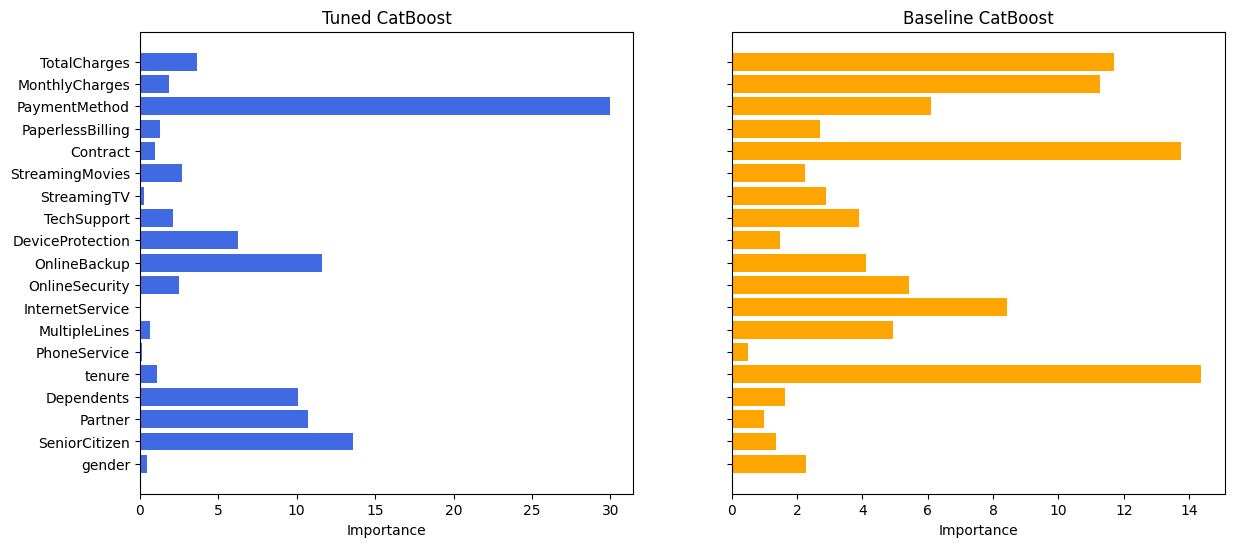

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].barh(fi["Feature"], fi["Tuned CatBoost Importance"], color="royalblue")
axes[0].set_title("Tuned CatBoost")
axes[0].set_xlabel("Importance")

axes[1].barh(fi["Feature"], fi["Baseline CatBoost Importance"], color="orange")
axes[1].set_title("Baseline CatBoost")
axes[1].set_xlabel("Importance")
plt.show()